In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tqdm

import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn import metrics



#potentially useful information

https://stackoverflow.com/questions/65671476/how-to-implement-a-forward-selection-using-knn //psedo code for implement stepwise feature selection using KNN


##Part1: data cleaning

In [ ]:
path = '/content/drive/Shared drives/COGS260 Note sure/project2/'
file = path + 'pitch.csv'

In [ ]:
df = pd.read_csv(file)
df

,last,first,mlbid,ab_id,pitch_id,start_speed,x0,z0,px,pz,pfx_x,pfx_z,stand,inning,height,spinrateND,spindirND,vxf,vzf,xangle,zangle,pitch_type
0,Rodriguez,Aneury,444553,6887541,14245211,86.0684,-1.324120,6.25999,-0.758226,1.62014,-2.080,8.200,R,3,75,820.336,195.8980,0.538850,-14.6846,-0.269637,7.30824,CH
1,Teheran,Julio,527054,8228606,18022090,85.5755,-2.207150,5.26623,0.552364,1.31787,-4.859,6.240,L,1,74,805.150,218.7140,4.472940,-13.8151,-2.229840,6.85765,CH
2,Jimenez,Ubaldo,434622,7964438,17092031,85.8323,-0.619724,6.76257,-0.744407,1.59281,-3.347,2.010,L,1,76,321.815,260.9620,-1.461970,-18.0544,0.726683,8.90224,CH
3,Scherzer,Max,453286,8114960,17665697,84.9790,-3.145990,5.38198,-1.206540,2.90910,-11.663,2.753,L,5,75,1682.120,260.8150,0.267519,-11.7972,-0.138128,6.06844,CH
4,Sanchez,Anibal,434671,7808426,16599671,84.6510,-0.393495,5.82921,-1.191840,2.44709,-4.850,2.420,L,1,72,570.194,254.6820,-3.453470,-13.8986,1.746070,6.99429,CH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6915,Neshek,Pat,450212,6703373,13707466,84.0416,-2.975120,4.27184,-0.635077,2.65202,-0.748,1.858,R,5,75,116.815,185.4750,4.904840,-10.2031,-2.476610,5.14125,SL
6916,Kinney,Josh,448337,7889815,16855336,84.5587,-2.929770,5.56422,-1.399180,2.82729,-1.808,-2.197,L,9,73,313.380,334.6120,2.766560,-14.0719,-1.391400,7.04297,SL
6917,Beachy,Brandon,545404,8286782,18244551,83.2670,-0.973477,6.64147,0.566804,1.22827,2.667,3.804,R,3,75,395.519,128.9380,4.298020,-17.8763,-2.177650,8.98720,SL
6918,Street,Huston,434718,8249825,18102994,85.0480,-1.962150,6.02637,0.313848,2.82613,-2.600,4.160,R,9,72,337.175,211.1860,4.139950,-12.8957,-2.103580,6.52707,SL


In [ ]:
df.columns

Index(['last', 'first', 'mlbid', 'ab_id', 'pitch_id', 'start_speed', 'x0',
       'z0', 'px', 'pz', 'pfx_x', 'pfx_z', 'stand', 'inning', 'height',
       'spinrateND', 'spindirND', 'vxf', 'vzf', 'xangle', 'zangle',
       'pitch_type'],
      dtype='object')

In [ ]:
#the dataframe doesn't have any null value
df.isna().any(axis = 0)

last           False
first          False
mlbid          False
ab_id          False
pitch_id       False
start_speed    False
x0             False
z0             False
px             False
pz             False
pfx_x          False
pfx_z          False
stand          False
inning         False
height         False
spinrateND     False
spindirND      False
vxf            False
vzf            False
xangle         False
zangle         False
pitch_type     False
dtype: bool

In [ ]:
df['pitch_type'].value_counts()


FA    2481
SI    1430
SL    1006
CU     731
CH     640
FC     425
FS     149
KN      49
CS       6
FO       2
EP       1
Name: pitch_type, dtype: int64

In [ ]:
# # get the rows with pitch types we want to drop
# pitches_to_drop = df[(df['pitch_type'] =='CS') | (df['pitch_type'] =='FO') | (df['pitch_type'] =='EP') ]

# df = df.drop(index = pitches_to_drop.index)
# df = df.reset_index(drop = True)
# df.head()

In [ ]:
# np.mean(df[(df['pitch_type'] =='KN')].start_speed)

#Part2: Shuffle to get Baseline ACC

In [ ]:
df2_shuff = df.drop(columns=['first','last','pitch_id','mlbid','ab_id','pitch_type']) #remove categorical variables in this new df
df2_shuff.stand = pd.get_dummies(df.stand).iloc[:,0].values
#create a array of neighbors, and a df to record knn results for the cell below
neighbors = np.arange(1,201)
scores_shuff = pd.DataFrame(columns=['neighbors','score','k'])
for k in np.arange(5):
  X_train, X_test, y_train, y_test = train_test_split(
      # shuffle pitch type
      df2_shuff, df.pitch_type.sample(frac=1), test_size=0.2, random_state=0)
  for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    score = knn.score(X_test, y_test)
    scores_shuff.loc[len(scores_shuff.index)] = [n,score,k]

In [ ]:
s_shuff = scores_shuff.groupby(by = ['neighbors']).mean().drop(columns = ['k'])
s_shuff[s_shuff.score == max(s_shuff.score)]

,score
neighbors,
156.0,0.356647


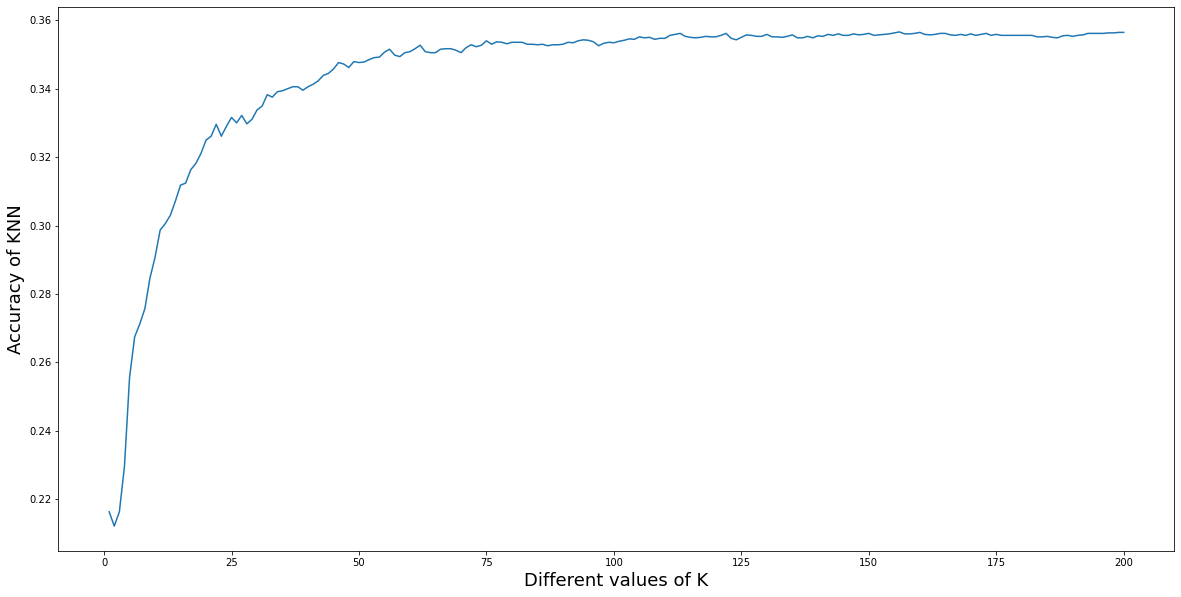

In [ ]:
fig = plt.figure(figsize = (20,10))
plt.plot(s_shuff['score']);
plt.xlabel('Different values of K',size = 18)
plt.ylabel('Accuracy of KNN',size = 18);

#Part3: KNN without Feature Selection

In [ ]:
df2 = df.drop(columns=['first','last','pitch_id','mlbid','ab_id','pitch_type']) #remove categorical variables in this new df
df2.stand = pd.get_dummies(df.stand).iloc[:,0].values
#create a array of neighbors, and a df to record knn results for the cell below
neighbors = np.arange(1,201)
scores = pd.DataFrame(columns=['neighbors','score','k'])

In [ ]:
df2

,start_speed,x0,z0,px,pz,pfx_x,pfx_z,stand,inning,height,spinrateND,spindirND,vxf,vzf,xangle,zangle
0,86.0684,-1.324120,6.25999,-0.758226,1.62014,-2.080,8.200,0,3,75,820.336,195.8980,0.538850,-14.6846,-0.269637,7.30824
1,85.5755,-2.207150,5.26623,0.552364,1.31787,-4.859,6.240,1,1,74,805.150,218.7140,4.472940,-13.8151,-2.229840,6.85765
2,85.8323,-0.619724,6.76257,-0.744407,1.59281,-3.347,2.010,1,1,76,321.815,260.9620,-1.461970,-18.0544,0.726683,8.90224
3,84.9790,-3.145990,5.38198,-1.206540,2.90910,-11.663,2.753,1,5,75,1682.120,260.8150,0.267519,-11.7972,-0.138128,6.06844
4,84.6510,-0.393495,5.82921,-1.191840,2.44709,-4.850,2.420,1,1,72,570.194,254.6820,-3.453470,-13.8986,1.746070,6.99429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6915,84.0416,-2.975120,4.27184,-0.635077,2.65202,-0.748,1.858,0,5,75,116.815,185.4750,4.904840,-10.2031,-2.476610,5.14125
6916,84.5587,-2.929770,5.56422,-1.399180,2.82729,-1.808,-2.197,1,9,73,313.380,334.6120,2.766560,-14.0719,-1.391400,7.04297
6917,83.2670,-0.973477,6.64147,0.566804,1.22827,2.667,3.804,0,3,75,395.519,128.9380,4.298020,-17.8763,-2.177650,8.98720
6918,85.0480,-1.962150,6.02637,0.313848,2.82613,-2.600,4.160,0,9,72,337.175,211.1860,4.139950,-12.8957,-2.103580,6.52707


In [ ]:
for k in np.arange(5):
  X_train, X_test, y_train, y_test = train_test_split(
      df2, df.pitch_type, test_size=0.2, random_state = 0 )
  for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    score = knn.score(X_test, y_test)
    scores.loc[len(scores.index)] = [n,score,k]

In [ ]:
for k in np.arange(5):
    print(np.mean(scores[scores['k'] == k].score))

0.634631502890174
0.6354985549132951
0.6381599229287095
0.640976637764933
0.6381057321772643


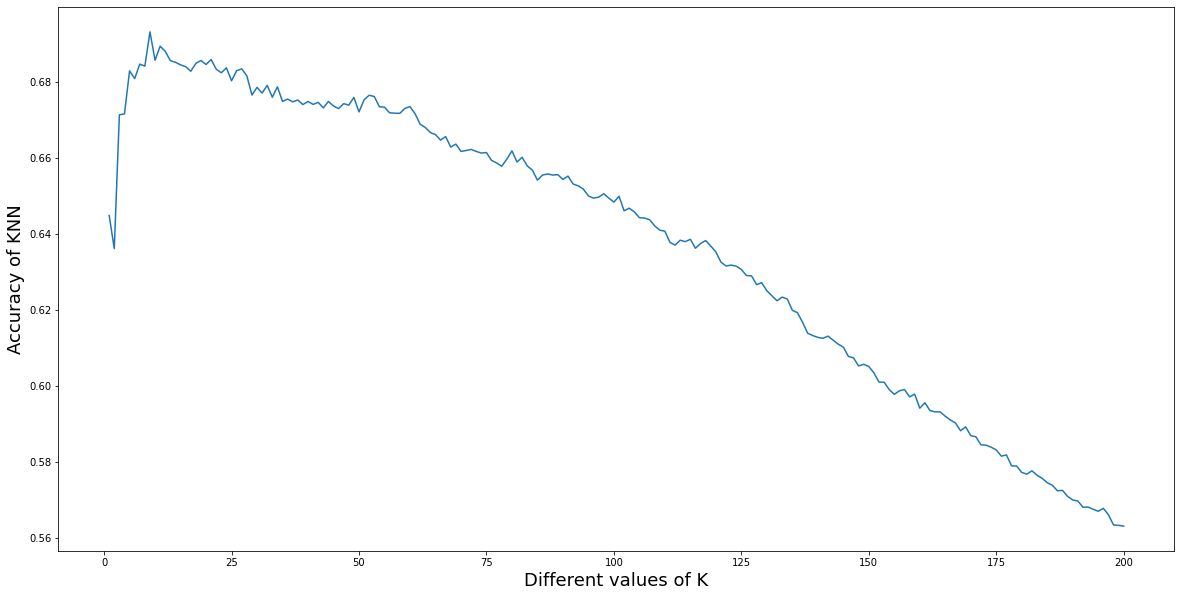

In [ ]:
s = scores.groupby(by = ['neighbors']).mean().drop(columns = ['k'])
fig = plt.figure(figsize = (20,10))
plt.plot(s['score']);
plt.xlabel('Different values of K',size = 18)
plt.ylabel('Accuracy of KNN',size = 18);

In [ ]:
#as we can see, the best k value is 9
max_k_value = s[s.score == max(s.score)]
max_k_value

,score
neighbors,
9.0,0.689234


# Part 4:best value of n_neighbors to fit KNN to entire dataset, predict pitch_types using the full X array, report final accuracy


In [ ]:
X = df2
y = df.pitch_type

# best num neighbors = 9
knn_best = KNeighborsClassifier(n_neighbors=9)
knn_best.fit(X, y)
knn_preds = knn_best.predict(X)

score_best = sum(knn_preds == y) / len(y)
score_best

0.7404624277456647

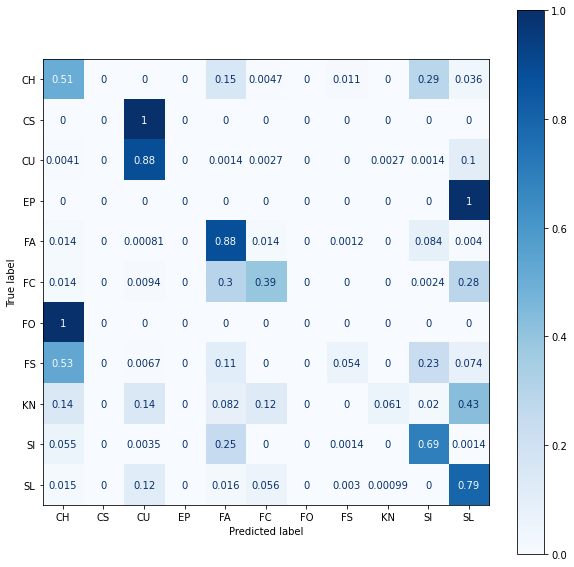

In [ ]:
confusion_matrix(y, knn_preds)
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(knn_best, X, y,  cmap=plt.cm.Blues, ax = ax, normalize = 'true')


#Part5: Stepwise feature selection > for inference purposes > see which features are BEST predictive of the pitch type

In [ ]:
#training model on Train dataset
knn = KNeighborsClassifier(n_neighbors = 9)
sfs1 = sfs(knn, k_features=16, forward=True, floating=False, verbose=2, scoring='accuracy')

sfs1.fit(X_train,y_train)
sfs1.k_feature_names_


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 membe

('start_speed',
 'x0',
 'z0',
 'px',
 'pz',
 'pfx_x',
 'pfx_z',
 'stand',
 'inning',
 'height',
 'spinrateND',
 'spindirND',
 'vxf',
 'vzf',
 'xangle',
 'zangle')

In [ ]:
y_train.shape

(5536,)

In [ ]:
sfs1

SequentialFeatureSelector(clone_estimator=True, cv=5,
                          estimator=KNeighborsClassifier(algorithm='auto',
                                                         leaf_size=30,
                                                         metric='minkowski',
                                                         metric_params=None,
                                                         n_jobs=None,
                                                         n_neighbors=9, p=2,
                                                         weights='uniform'),
                          floating=False, forward=True, k_features=16, n_jobs=1,
                          pre_dispatch='2*n_jobs', scoring='accuracy',
                          verbose=2)

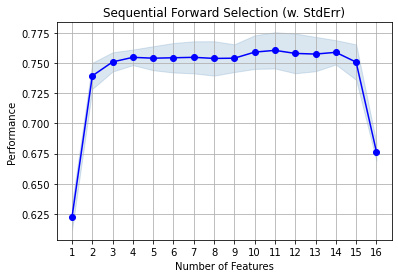

In [ ]:
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

From the plot above we can see that the best subset for us to include is 2

In [ ]:
#training model on Train dataset
knn = KNeighborsClassifier(n_neighbors = 9)
sfs2 = sfs(knn, k_features=2, forward=True, floating=False, verbose=2, scoring='accuracy')

sfs2.fit(X_train,y_train)
sfs2.k_feature_names_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 membe

('start_speed', 'spindirND')

In [ ]:
# Generate the new subsets based on the selected features
# Note that the transform call is equivalent to
# X_train[:, sfs1.k_feature_idx_]

X_train_sfs = sfs2.transform(X_train)
X_test_sfs = sfs2.transform(X_test)

# Fit the estimator using the new feature subset
# and make a prediction on the test data
knn.fit(X_train_sfs, y_train)
y_pred = knn.predict(X_test_sfs)

# Compute the accuracy of the prediction
acc = float((y_test == y_pred).sum()) / y_pred.shape[0]
print('Test set accuracy: %.2f %%' % (acc * 100))

Test set accuracy: 73.34 %


In [ ]:

y_pred

array(['FA', 'FA', 'FA', ..., 'SI', 'SL', 'SI'], dtype=object)

In [ ]:
X_test_sfs

array([[ 93.7095, 173.081 ],
       [ 93.2142, 209.177 ],
       [ 93.4081, 213.108 ],
       ...,
       [ 93.6189, 259.273 ],
       [ 88.5166,  50.9915],
       [ 91.2967, 243.801 ]])

In [ ]:
X_test['pred'] = list(y_pred)
X_test.pred.value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



FA    545
SI    285
SL    196
CH    149
CU    130
FC     69
FS     10
Name: pred, dtype: int64

In [ ]:
df_all = X_test.copy()
df_all['true_PT'] = y_test

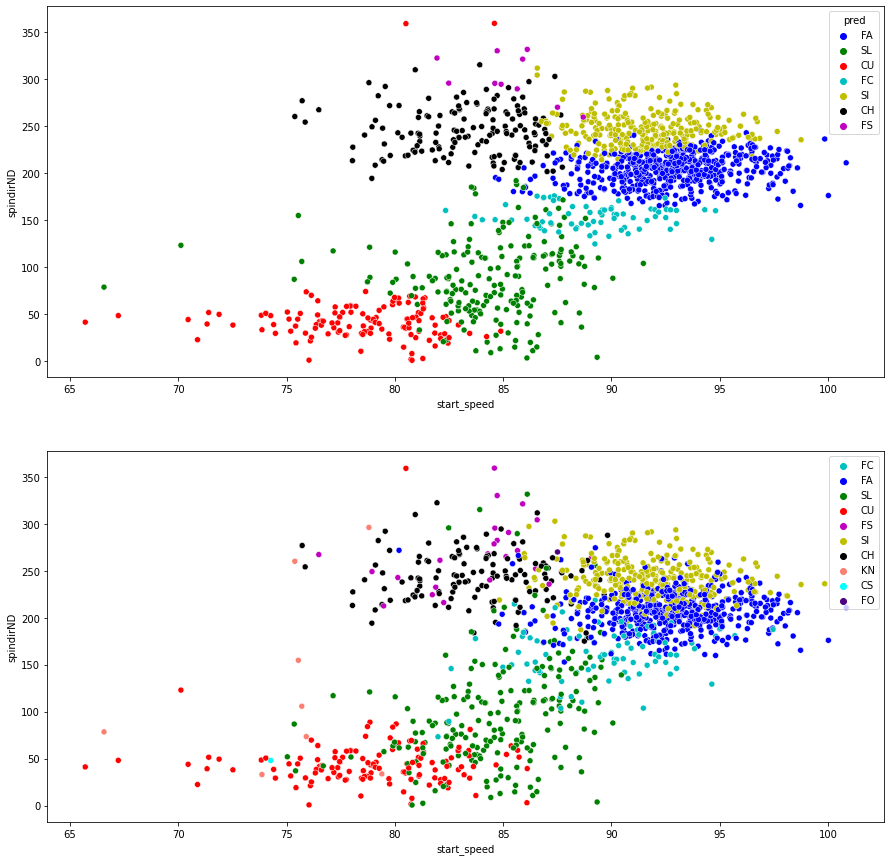

In [ ]:
#the predicted value of X_test
fig, (ax1, ax2) = plt.subplots(2,figsize = (15,15))
# plt.label(loc = 'upper right')

c = {'FA': 'b', 'SL':'g', 'CU':'r','FC':'c', 'SI':'y', 'CH':'k','FS': 'm',
     'KN': 'salmon', 'FO':'indigo', 'CS':'aqua'}
sns.set_palette(sns.color_palette())

sns.scatterplot(x ='start_speed',y = 'spindirND',hue  = 'pred', data = X_test, palette = c, ax = ax1)
sns.scatterplot(x ='start_speed',y = 'spindirND',hue  = 'true_PT', data = df_all,palette = c, ax = ax2)
ax2.legend(loc='upper right')

